In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import scipy.io
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [ ]:
# ====================== DATA LOADING ======================

def load_emnist_digits(path='emnist-digits.mat'):
    data = scipy.io.loadmat(path)
    
    # Access MATLAB structure 
    train_images = data['dataset']['train'][0][0]['images'][0][0]
    train_labels = data['dataset']['train'][0][0]['labels'][0][0]
    test_images = data['dataset']['test'][0][0]['images'][0][0]
    test_labels = data['dataset']['test'][0][0]['labels'][0][0]
    
    # Some preprocessing
    x_train = train_images.reshape(-1, 28, 28).transpose(0, 2, 1).astype(np.float32)
    y_train = train_labels.flatten().astype(np.int64)
    x_test = test_images.reshape(-1, 28, 28).transpose(0, 2, 1).astype(np.float32)
    y_test = test_labels.flatten().astype(np.int64)
    
    # Normalization
    x_train /= 255.0
    x_test /= 255.0
    
    return x_train, y_train, x_test, y_test

In [ ]:
def prepare_emnist():
    x_train, y_train, x_test, y_test = load_emnist_digits()
    
    # Convert to PyTorch tensors
    train_data = TensorDataset(
        torch.from_numpy(x_train).unsqueeze(1),  # Add channel dimension
        torch.from_numpy(y_train)
    )
    test_data = TensorDataset(
        torch.from_numpy(x_test).unsqueeze(1),
        torch.from_numpy(y_test)
    )
    
    return (
        DataLoader(train_data, batch_size=128, shuffle=True),
        DataLoader(test_data, batch_size=128, shuffle=False)
    )

In [ ]:
# ready to use no need for pre processing
def prepare_mnist():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    return (
        DataLoader(train_set, batch_size=128, shuffle=True),
        DataLoader(test_set, batch_size=128, shuffle=False)
    )

In [ ]:
# ====================== ANN MODEL DEFINITION ====================== #

class DigitRecognizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(  
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
            )
    
    def forward(self, x):
        x = self.flatten(x)
        return self.network(x)


In [ ]:
# training loop
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

In [ ]:

def evaluate_model(model, test_loader, dataset_name):
    """Evaluation function"""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    #print(f"{dataset_name} Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [ ]:
# ====================== EXECUTION ======================

model_mnist = DigitRecognizer().to(device)


# Loss and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_mnist = optim.Adam(model_mnist.parameters(), lr=0.001)

# Prepare datasets
mnist_train, mnist_test = prepare_mnist()


# Train and evaluate MNIST model
print("\nTraining MNIST model...")
train_model(model_mnist, mnist_train, criterion, optimizer_mnist, epochs=10)
mnist_acc = evaluate_model(model_mnist, mnist_test, "MNIST")


# Accuracy
print(f"MNIST Model Accuracy: {mnist_acc:.2f}%")


# Save models
#torch.save(model_mnist.state_dict(), 'mnist_model.pth')




Training MNIST model...
Epoch 1/10, Loss: 0.2291
Epoch 2/10, Loss: 0.0871
Epoch 3/10, Loss: 0.0605
Epoch 4/10, Loss: 0.0425
Epoch 5/10, Loss: 0.0334
Epoch 6/10, Loss: 0.0283
Epoch 7/10, Loss: 0.0255
Epoch 8/10, Loss: 0.0195
Epoch 9/10, Loss: 0.0169
Epoch 10/10, Loss: 0.0158
MNIST Model Accuracy: 98.22%


In [ ]:


# Initialize models

model_emnist = DigitRecognizer().to(device)

# Loss and optimizers
optimizer_emnist = optim.Adam(model_emnist.parameters(), lr=0.001)

# Prepare datasets
emnist_train, emnist_test = prepare_emnist()



# Train and evaluate EMNIST model
print("\nTraining EMNIST model...")
train_model(model_emnist, emnist_train, criterion, optimizer_emnist, epochs=10)
emnist_acc = evaluate_model(model_emnist, emnist_test, "EMNIST")

# Accuracy
print(f"EMNIST Model Accuracy: {emnist_acc:.2f}%")

# Save models

#torch.save(model_emnist.state_dict(), 'emnist_model.pth')
#print("\nModels saved to emnist_model.pth")


Training EMNIST model...
Epoch 1/10, Loss: 0.1186
Epoch 2/10, Loss: 0.0464
Epoch 3/10, Loss: 0.0339
Epoch 4/10, Loss: 0.0273
Epoch 5/10, Loss: 0.0223
Epoch 6/10, Loss: 0.0191
Epoch 7/10, Loss: 0.0161
Epoch 8/10, Loss: 0.0138
Epoch 9/10, Loss: 0.0127
Epoch 10/10, Loss: 0.0108
EMNIST Model Accuracy: 98.91%

Models saved to emnist_model.pth


In [ ]:
# ====================== CNN MODEL ======================
class DigitCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            #28x28
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
                # 28x28x32
            nn.ReLU(),
            # 28x28x32
            nn.MaxPool2d(2),  
            # 14x14x32
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  
            # 14x14x64
            nn.ReLU(),
            # 14x14x64
            nn.MaxPool2d(2) 
            # 7x7x64
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7*7*64, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [ ]:

# Initialize models
cnn_mnist = DigitCNN().to(device)


# Loss and optimizers

optimizer_mnist = optim.Adam(cnn_mnist.parameters(), lr=0.001)




# Train and evaluate MNIST model
print("\nTraining MNIST CNN model...")
train_model(cnn_mnist, mnist_train, criterion, optimizer_mnist, epochs=10)
mnist_acc = evaluate_model(cnn_mnist, mnist_test, "MNIST")


# Accuracy
print(f"MNIST CNN Accuracy: {mnist_acc:.2f}%")


# Save models
#torch.save(cnn_mnist.state_dict(), 'cnn_mnist.pth')



Training MNIST CNN model...
Epoch 1/10, Loss: 0.1643
Epoch 2/10, Loss: 0.0475
Epoch 3/10, Loss: 0.0348
Epoch 4/10, Loss: 0.0242
Epoch 5/10, Loss: 0.0186
Epoch 6/10, Loss: 0.0155
Epoch 7/10, Loss: 0.0126
Epoch 8/10, Loss: 0.0105
Epoch 9/10, Loss: 0.0096
Epoch 10/10, Loss: 0.0057
MNIST CNN Accuracy: 99.13%


In [ ]:


# Initialize models
cnn_emnist = DigitCNN().to(device)

# Loss and optimizers


optimizer_emnist = optim.Adam(cnn_emnist.parameters(), lr=0.001)


# Train and evaluate EMNIST model
print("\nTraining EMNIST CNN model...")
train_model(cnn_emnist, emnist_train, criterion, optimizer_emnist, epochs=10)
emnist_acc = evaluate_model(cnn_emnist, emnist_test, "EMNIST")

# Accuracy
print(f"EMNIST CNN Accuracy: {emnist_acc:.2f}%")

# Save models

#torch.save(cnn_emnist.state_dict(), 'cnn_emnist.pth')



Training EMNIST CNN model...
Epoch 1/10, Loss: 0.0793
Epoch 2/10, Loss: 0.0268
Epoch 3/10, Loss: 0.0198
Epoch 4/10, Loss: 0.0154
Epoch 5/10, Loss: 0.0122
Epoch 6/10, Loss: 0.0094
Epoch 7/10, Loss: 0.0074
Epoch 8/10, Loss: 0.0063
Epoch 9/10, Loss: 0.0048
Epoch 10/10, Loss: 0.0041
EMNIST CNN Accuracy: 99.45%


In [17]:
import cv2
import torch.nn.functional as F
from PIL import Image
import numpy as np

def predict_digit(image_path, model_path='cnn_emnist.pth', model_type='cnn'):

    # Load the appropriate model
    if model_type == 'cnn':
        model = DigitCNN()
    else:
        model = DigitRecognizer()
    
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    
    # Preprocess the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = image.resize((28, 28))  # Resize to 28x28
    
    # Convert to numpy array and normalize
    image_array = np.array(image)
    image_array = image_array.astype(np.float32) / 255.0
    
    # Invert colors if needed (MNIST/EMNIST digits are white on black background)
    if np.mean(image_array) > 0.5:  # If background is lighter than foreground
        image_array = 1 - image_array
    
    # Add batch and channel dimensions
    if model_type == 'cnn':
        image_tensor = torch.from_numpy(image_array).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 28, 28]
    else:
        image_tensor = torch.from_numpy(image_array).unsqueeze(0)  # Shape: [1, 28, 28]
    
    image_tensor = image_tensor.to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        confidence, prediction = torch.max(probabilities, 1)
    
    return prediction.item(), confidence.item()

def show_prediction(image_path, model_path='cnn_emnist.pth', model_type='cnn'):
    digit, confidence = predict_digit(image_path, model_path, model_type)
    
    # Display the image
    image = Image.open(image_path)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(f'Predicted: {digit} (Confidence: {confidence:.2%})')
    plt.show()
    
    return digit, confidence

C:\Users\hello\AppData\Local\Temp\ipykernel_19120\3222740756.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Predicted digit: 5 with confidence 64.49%


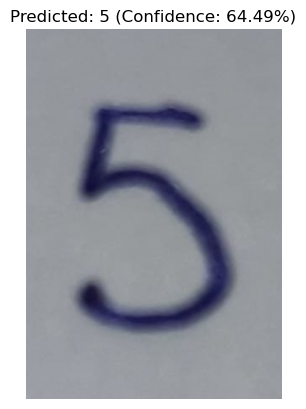

(5, 0.6449324488639832)

In [18]:
# For simple prediction
digit, confidence = predict_digit('n.jpg')
print(f"Predicted digit: {digit} with confidence {confidence:.2%}")

# For visualization
show_prediction('n.jpg')